In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec as mpgs
import matplotlib as mpl
import numpy as np
import scipy as sp
from skimage import transform as skt
import os
import time
import multiprocessing as mp
import skimage.filters as skf
from scipy import ndimage as scnd
import hdf5storage as h5
from matplotlib_scalebar.scalebar import ScaleBar,SI_LENGTH_RECIPROCAL
import math
import numba
import sys
import pyfftw
import pymcr
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 35})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'figure.autolayout': True})

In [2]:
import sys
sys.path.append('/home/cades/Codes/stemtools')
import stemtools as st
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
st.pty.wavelength_pm(60)

4.866059983164618

In [17]:
st.pty.fourier_calib(5,(1024,1024))

(0.00019531250000000278, 0.00019531250000000278)

In [6]:
@numba.jit(parallel=True)
def make_probe(aperture,voltage,image_x,image_y,calibration_pm):
    """
    This calculates an ideal aberration free probe based on the size and the estimated Fourier co-ordinates
    """ 
    aperture = aperture / 1000
    wavelength = wavelength_pm(voltage)
    LMax = aperture / wavelength
    x_FOV = image_x * calibration_pm
    y_FOV = image_y * calibration_pm
    qx = (np.arange((-image_x / 2),(image_x / 2), 1)) / x_FOV
    x_shifter = (round(image_x / 2))
    qy = (np.arange((-image_y / 2),(image_y / 2), 1)) / y_FOV
    y_shifter = (round(image_y / 2))
    Lx = np.roll(qx, x_shifter)
    Ly = np.roll(qy, y_shifter)
    Lya, Lxa = np.meshgrid(Lx, Ly)
    L2 = np.multiply(Lxa, Lxa) + np.multiply(Lya, Lya)
    inverse_real_matrix = L2 ** 0.5
    fourier_scan_coordinate = Lx[1] - Lx[0]
    Adist = ((LMax - inverse_real_matrix) /
             fourier_scan_coordinate) + 0.5
    Adist[Adist < 0] = 0
    Adist[Adist > 1] = 1
    return (np.fft.fftshift(Adist),fourier_scan_coordinate)

In [8]:
@numba.jit(parallel=True)
def my_wiener(convolved,convolver):
    convolved_fft = np.fft.ifftshift(np.fft.ifft2(convolved))
    convolver_fft = np.fft.fft2(convolver)
    convolver_fft_conj = np.conj(convolver_fft)
    conj_mult = np.multiply(convolved_fft,convolver_fft_conj)
    denom = (np.abs(convolver_fft)) ** 2
    epsi = 0.01 * np.amax(denom)
    convolvee_fft = np.divide(conj_mult,(epsi + denom))
    convolvee = np.fft.ifftshift(np.fft.ifft2(convolvee_fft))
    return convolvee

Text(0.5, 1.0, 'Beam in Diffraction Plane')

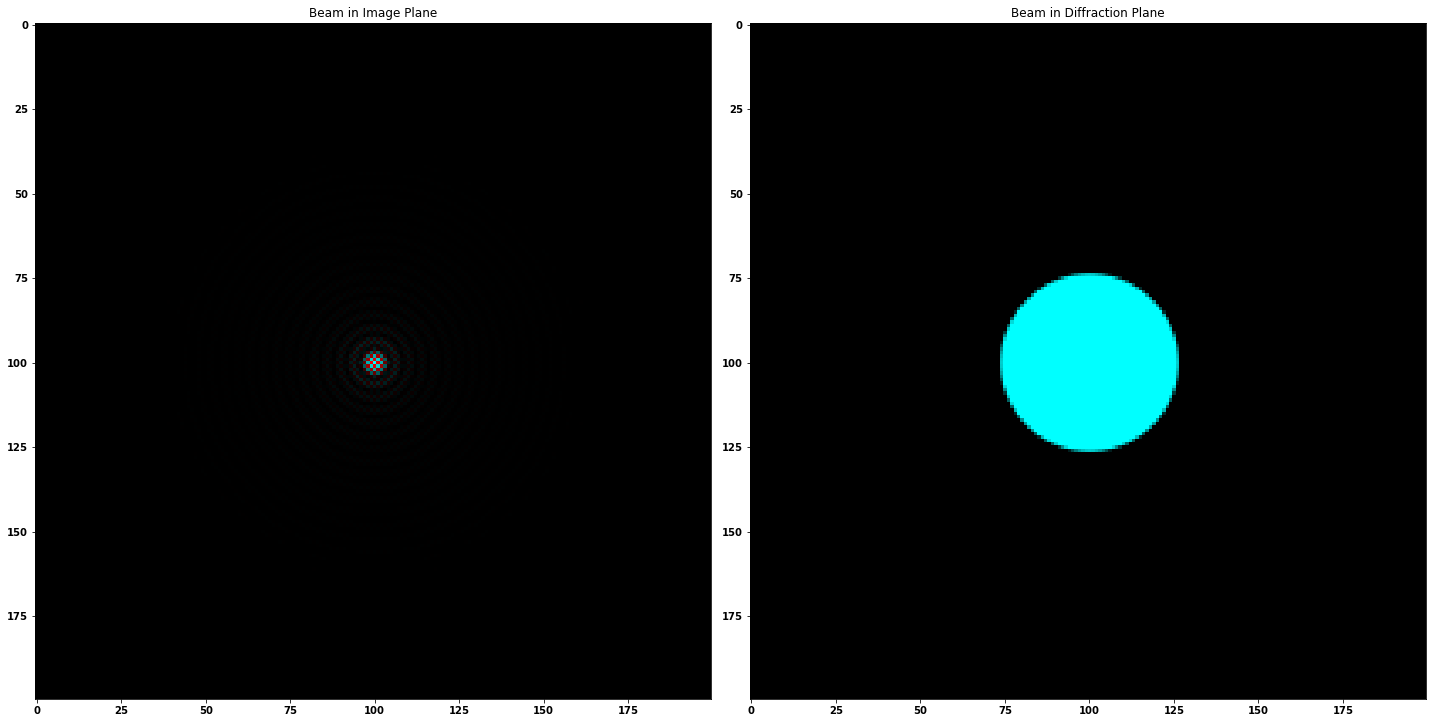

In [10]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cp_image_val(np.fft.fftshift(np.fft.fft2(test_beam))))
plt.title('Beam in Image Plane')

plt.subplot(1, 2, 2)
plt.imshow(cp_image_val(test_beam))
plt.title('Beam in Diffraction Plane')

In [11]:
upper_thresh = skf.threshold_otsu(np.abs(np.fft.fftshift(test_beam)))
lower_thresh = (-1)*(skf.threshold_otsu((-1)*(np.abs(test_beam))))
canny_test = skf.apply_hysteresis_threshold(np.abs(test_beam), lower_thresh, upper_thresh)

In [12]:
from skimage import io, measure, draw, img_as_bool
from scipy import optimize

image = canny_test.astype(int)
regions = measure.regionprops(image)
bubble = regions[0]
y_center, x_center = bubble.centroid
radius = bubble.major_axis_length / 2.

@numba.jit(parallel=True)
def cost(params):
    x0, y0, r = params
    coords = draw.circle(y0, x0, r, shape=image.shape)
    template = np.zeros_like(image)
    template[coords] = 1
    return -np.sum(template == image)

x_center, y_center, radius = optimize.fmin(cost, (x_center, y_center, radius))

Optimization terminated successfully.
         Current function value: -40000.000000
         Iterations: 38
         Function evaluations: 98


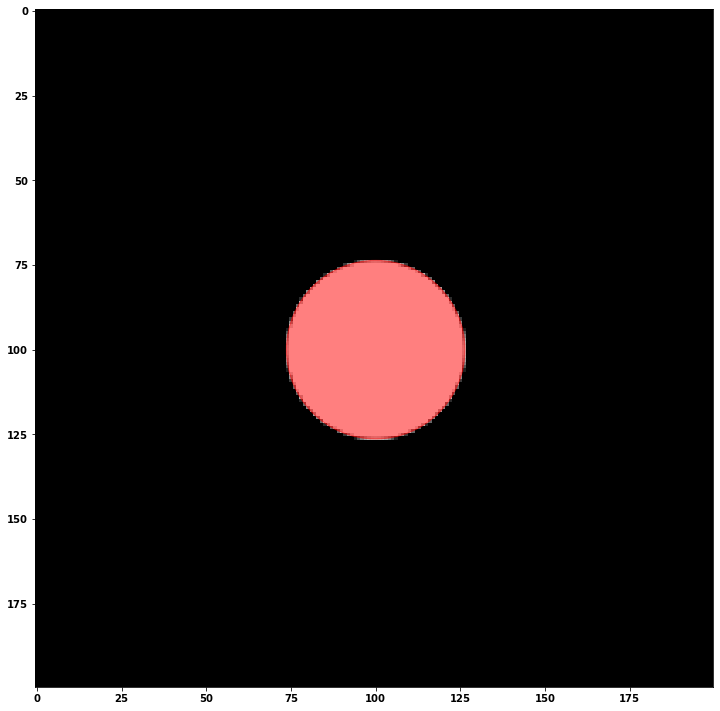

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
fitted_circle = plt.Circle((x_center, y_center), radius,color="red",alpha=0.5)
ax.imshow(np.abs(test_beam), cmap='gray')
ax.add_artist(fitted_circle)
plt.show()

In [14]:
(aperture_mrad/(1000*radius*fourier_pix))/wavelength_pm(60)

0.9974215079305664

In [15]:
@numba.jit(parallel=True)
def wigner_1d(data_array):
    data_length = np.amax((np.asarray(data_array.shape)).astype(int))
    orig_dom = np.arange(data_length)
    [trow, tcol] = np.shape(np.array([orig_dom]))
    tfr = np.zeros((data_length, data_length), dtype='complex')
    for icol in np.arange(data_length):
        ti = orig_dom[icol]
        taumax = min([ti, data_length-ti-1, int(round(data_length/2.0))-1])
        tau = np.arange(-taumax, taumax+1)
        indices = ((data_length + tau) % data_length)
        tfr[np.ix_(indices, [icol])] = np.transpose(np.array(data_array[ti+tau] * np.conj(data_array[ti-tau]), ndmin=2))
        tau=int(round(data_length/2))+1
        if ((ti + 1) <= (data_length - tau)) and ((ti + 1) >= (tau + 1)):
            if(tau >= tfr.shape[0]): 
                tfr = np.append(tfr, np.zeros([1, tcol]), axis=0)
            tfr[np.ix_([tau], [icol])] = np.array(0.5 * (data_array[ti+tau] * np.conj(data_array[ti-tau]) +\
                                                         data_array[ti-tau] * np.conj(data_array[ti+tau])))
    
    wigner_dist = np.fft.fft(tfr, axis=0)
    freq_dom = 0.5*np.arange(data_length)/float(data_length)
    return (orig_dom, freq_dom, wigner_dist)

In [16]:
@numba.jit(parallel=True)
def positive_wigner_1d(data_array):
    data_length = np.amax((np.asarray(data_array.shape)).astype(int))
    orig_dom = np.arange(data_length)
    [trow, tcol] = np.shape(np.array([orig_dom]))
    tfr = np.zeros((data_length, data_length), dtype='complex')
    for icol in np.arange(data_length):
        ti = orig_dom[icol]
        taumax = min([ti, data_length-ti-1, int(round(data_length/2.0))-1])
        tau = np.arange(-taumax, taumax+1)
        indices = ((data_length + tau) % data_length)
        tfr[np.ix_(indices, [icol])] = np.transpose(np.array(data_array[ti+tau] * np.conj(data_array[ti-tau]), ndmin=2))
        tau=int(round(data_length/2))+1
        if ((ti + 1) <= (data_length - tau)) and ((ti + 1) >= (tau + 1)):
            if(tau >= tfr.shape[0]): 
                tfr = np.append(tfr, np.zeros([1, tcol]), axis=0)
            tfr[np.ix_([tau], [icol])] = np.array(0.5 * (data_array[ti+tau] * np.conj(data_array[ti-tau]) +\
                                                         data_array[ti-tau] * np.conj(data_array[ti+tau])))
    
    wigner_dist = np.fft.fftshift(np.fft.fft(tfr, axis=0),axes=0)
    freq_dom = 0.5*np.arange(data_length)/float(data_length)
    return (orig_dom, freq_dom, wigner_dist)

@numba.jit(parallel=True)
def negative_wigner_1d(data_array):
    data_length = np.amax((np.asarray(data_array.shape)).astype(int))
    orig_dom = np.arange(data_length)
    [trow, tcol] = np.shape(np.array([orig_dom]))
    tfr = np.zeros((data_length, data_length), dtype='complex')
    for icol in np.arange(data_length):
        ti = orig_dom[icol]
        taumax = min([ti, data_length-ti-1, int(round(data_length/2.0))-1])
        tau = np.arange(-taumax, taumax+1)
        indices = ((data_length + tau) % data_length)
        tfr[np.ix_(indices, [icol])] = np.transpose(np.array(data_array[ti+tau] * np.conj(data_array[ti-tau]), ndmin=2))
        tau=int(round(data_length/2))+1
        if ((ti + 1) <= (data_length - tau)) and ((ti + 1) >= (tau + 1)):
            if(tau >= tfr.shape[0]): 
                tfr = np.append(tfr, np.zeros([1, tcol]), axis=0)
            tfr[np.ix_([tau], [icol])] = np.array(0.5 * (data_array[ti+tau] * np.conj(data_array[ti-tau]) +\
                                                         data_array[ti-tau] * np.conj(data_array[ti+tau])))
    
    wigner_dist = np.fft.ifftshift(np.fft.ifft(tfr, axis=0),axes=0)
    freq_dom = 0.5*np.arange(data_length)/float(data_length)
    return (orig_dom, freq_dom, wigner_dist)

In [17]:
voltage = 60
aperture_mrad = 32
imagex = 2*200
imagey = 2*200
calibration_pm = 20
test_beam_2,fourier_pix = make_probe(aperture_mrad,voltage,imagex,imagey,calibration_pm)

Text(0.5, 1.0, 'Beam in Diffraction Plane')

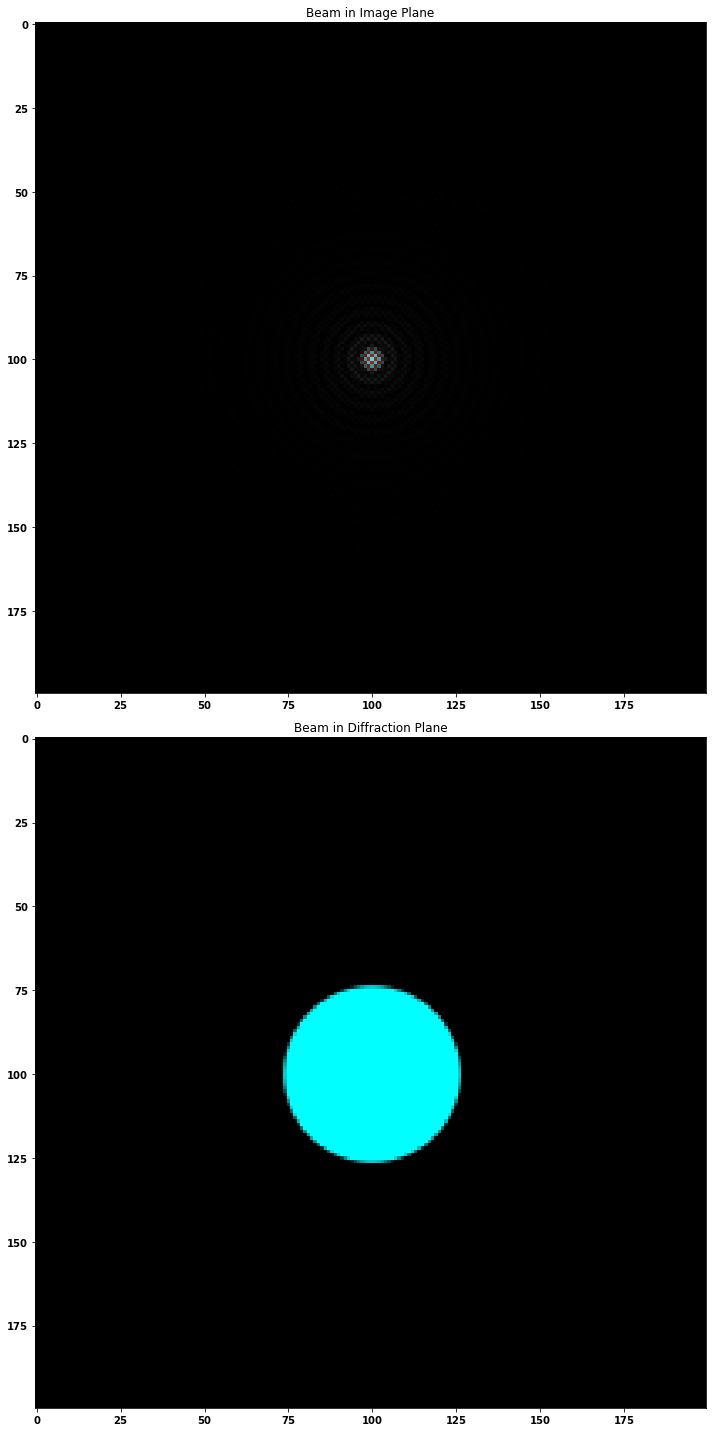

In [18]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
plt.imshow(cp_image_val(np.fft.fftshift(np.fft.fft2(test_beam))))
plt.title('Beam in Image Plane')

plt.subplot(2, 1, 2)
plt.imshow(cp_image_val(test_beam))
plt.title('Beam in Diffraction Plane')

In [19]:
def cropimage(image,cropmatrix,cropsize):
    croprows = np.zeros(2).astype(int)
    cropcols = np.zeros(2).astype(int)
    cropped_image = np.zeros(cropsize)
    croprows[0] = cropmatrix[0] - int(round(cropsize[0]/2))
    croprows[1] = cropmatrix[0] + int(round(cropsize[0]/2)) 
    cropcols[0] = cropmatrix[1] - int(round(cropsize[1]/2))
    cropcols[1] = cropmatrix[1] + int(round(cropsize[1]/2)) 
    cropped_image = image[croprows[0]:croprows[1],cropcols[0]:cropcols[1]]
    return cropped_image

In [20]:
@numba.jit(parallel=True)
def move_by_phase(image_to_move, x_pixels, y_pixels):
    image_size = (np.asarray(np.shape(image_to_move))).astype(int)
    fourier_cal_y = np.linspace((-image_size[0] / 2), ((image_size[0] / 2) - 1), image_size[0])
    fourier_cal_y = fourier_cal_y / image_size[0]
    fourier_cal_x = np.linspace((-image_size[1] / 2), ((image_size[1] / 2) - 1), image_size[1])
    fourier_cal_x = fourier_cal_x / image_size[1]
    [fourier_cal_x, fourier_cal_y] = np.meshgrid(fourier_cal_x, fourier_cal_y)
    move_matrix = (fourier_cal_x * x_pixels) + (fourier_cal_y * y_pixels)
    move_phase = np.exp((-2) * math.pi * 1j * move_matrix)
    original_image_fft = np.fft.fftshift(np.fft.fft2(image_to_move))
    moved_image = np.fft.ifftshift(np.fft.ifft2(np.multiply(move_phase, original_image_fft)))
    return moved_image

@numba.jit(parallel=True)
def make_wigner_probe(aperture,voltage,image_x,image_y,calibration_pm):
    tb,fourier_pix = make_probe(aperture_mrad,voltage,(2*image_x),(2*image_y),calibration_pm)
    mainbeam = cropimage(tb,(image_x,image_y),(image_x,image_y))
    wigner_beam = np.zeros((image_x,image_y,image_x,image_y)).astype(complex)
    for rows_x in range(image_x):
        for rows_y in range(image_y):
            xpos = rows_x - (image_x/2)
            ypos = rows_y - (image_y/2)
            movedbeam = cropimage((move_by_phase(tb,xpos,ypos)),(image_x,image_y),(image_x,image_y))
            wigner_beam[:,:,rows_x,rows_y] = np.multiply(np.conj(mainbeam),movedbeam)
    wigner_beam = np.transpose(wigner_beam,(2,3,0,1))
    wigner_beam = np.fft.fft2(wigner_beam,axes=(2,3))
    wigner_beam = np.fft.fftshift(wigner_beam,axes=(2,3))
    return wigner_beam

In [21]:
mainbeam_ft = test_beam
moved_ft = scnd.interpolation.shift(mainbeam_ft,(-20,-20))
conv_ft = np.multiply(np.conj(mainbeam_ft),moved_ft)

In [22]:
@numba.jit(parallel=True)
def fft_wigner_probe(aperture,voltage,image_x,image_y,calibration_pm,intensity_param):
    tb,fourier_pix = make_probe(aperture_mrad,voltage,image_x,image_y,calibration_pm)
    fourier_beam = tb/intensity_param
    wigner_beam = np.zeros((image_x,image_y,image_x,image_y)).astype(complex)
    for rows_x in numba.prange(image_x):
        for rows_y in range(image_y):
            xpos = rows_x - (image_x/2)
            ypos = rows_y - (image_y/2)
            moved_fourier_beam = scnd.interpolation.shift(fourier_beam,(-xpos,-ypos))
            convolved_beam = np.multiply(np.conj(fourier_beam),moved_fourier_beam)
            wigner_beam[:,:,rows_x,rows_y] = convolved_beam
    return wigner_beam

In [23]:
retval = os.getcwd()
path = "/home/cades/Data4D_2/Debangshu/TMD 4D-STEM/Nion Swift Library 20190126 MoSe2 CVD B17"
os.chdir(path)

In [25]:
st.tic()
file4D = "Data4_4D.npy"
fileADF = "Data4_ADF.npy"
json4D = "Data4_4D.json"
jsonADF = "Data4_ADF.json"
st.toc()

Elapsed time: 0.000212 seconds.



In [26]:
data4D = np.load(file4D)
dataADF = np.load(fileADF)
with open(json4D) as json_data:
    info4D = json.load(json_data)
with open(jsonADF) as json_data:
    infoADF = json.load(json_data)
del json_data

In [27]:
pixel_calibration_pm = 1000*infoADF['spatial_calibrations'][1]['scale']
pixel_calibration_pm

22.22222222222222

In [28]:
chop_pixel = image_x
data4D_chop1 = data4D[0:chop_pixel,0:chop_pixel,:,:]
st.tic()
data_rc = np.transpose(data4D_chop1,(2,3,0,1))
st.toc()

Elapsed time: 0.000114 seconds.



In [29]:
@numba.jit(parallel=True)
def flip_corrector(data4D):
    datasize = (np.asarray(data4D.shape)).astype(int)
    flipped4D = np.zeros((datasize[0],datasize[1],datasize[2],datasize[3]))
    for jj in numba.prange(datasize[3]):
        for ii in range(datasize[2]):
            ronchi = data4D[:,:,ii,jj]
            ronchi_flip = np.fliplr(ronchi)
            flipped4D[:,:,ii,jj] = ronchi_flip
    return flipped4D

In [30]:
data_rc.shape

(128, 128, 200, 200)

In [31]:
%timeit flip_corrector(data_rc[:,:,0:50,0:50])

1.06 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
st.tic()
data_rc = flip_corrector(data_rc)
st.toc()

Elapsed time: 25.821872 seconds.



In [33]:
Mean_Ronchigram = np.mean(data_rc,axis=(2,3))
upper_thresh = skf.threshold_otsu(Mean_Ronchigram)
lower_thresh = (-1)*(skf.threshold_otsu(-Mean_Ronchigram))
canny_ronchi = skf.apply_hysteresis_threshold(Mean_Ronchigram, lower_thresh, upper_thresh)

In [34]:
aperture_mrad = 32

In [35]:
from skimage import io, measure, draw, img_as_bool
from scipy import optimize

image = canny_ronchi.astype(int)
regions = measure.regionprops(image)
bubble = regions[0]
y_center, x_center = bubble.centroid
radius = bubble.major_axis_length / 2.

def cost(params):
    x0, y0, r = params
    coords = draw.circle(y0, x0, r, shape=image.shape)
    template = np.zeros_like(image)
    template[coords] = 1
    return -np.sum(template == image)

x_center, y_center, radius = optimize.fmin(cost, (x_center, y_center, radius))

Optimization terminated successfully.
         Current function value: -16303.000000
         Iterations: 36
         Function evaluations: 99


In [36]:
fourier_calibration_pm = (aperture_mrad/(1000*wavelength_pm(60)))/radius
fourier_calibration_nm = 1000*fourier_calibration_pm

In [37]:
tt,fourier_pixel = make_probe(aperture_mrad,60,200,200,pixel_calibration_pm)
sampling_ratio = fourier_calibration_pm/fourier_pixel
sampling_ratio

0.5993147645020662

If sampling ratio is greater than 1, we need to downsample the diffraction pattern, else we need to upsample.

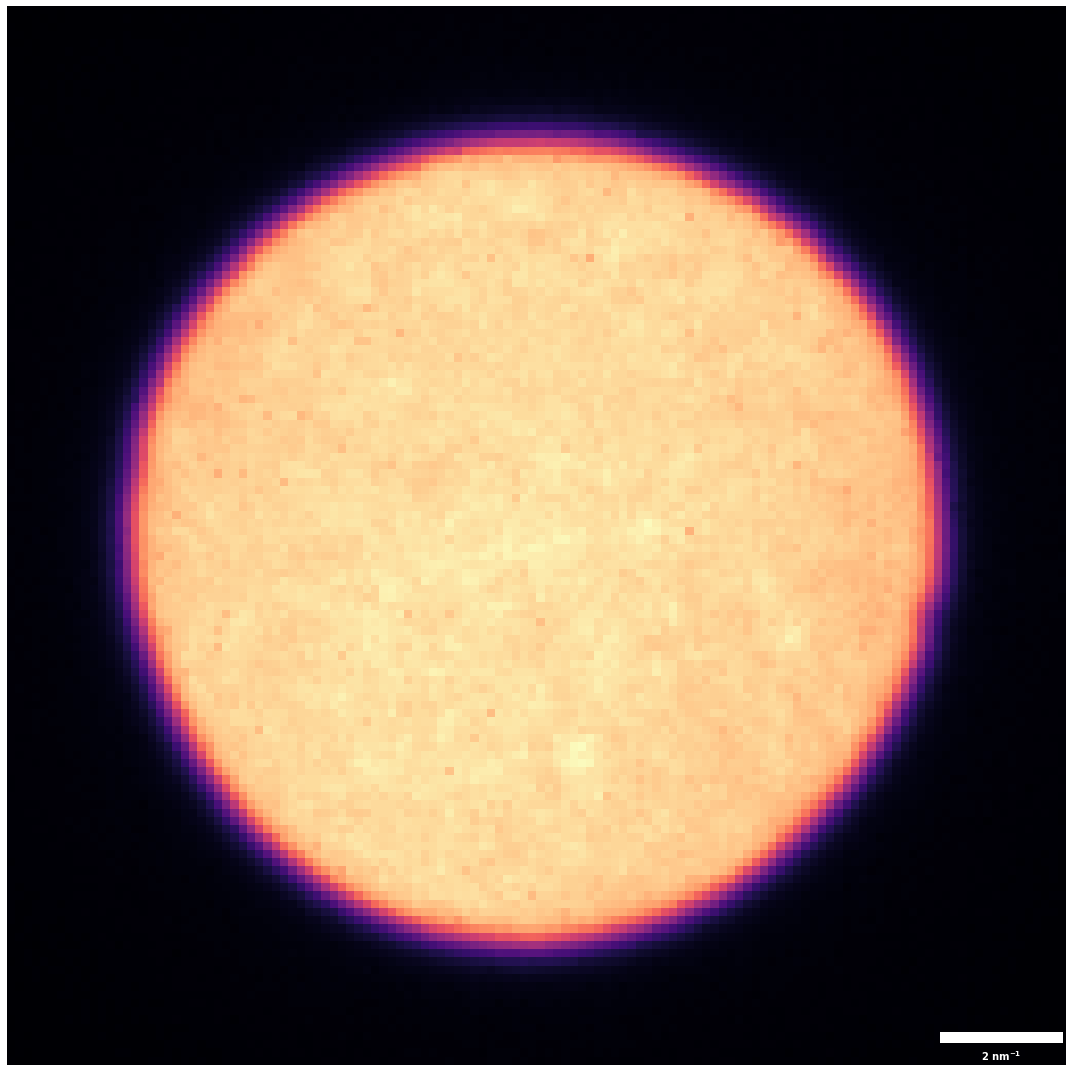

In [38]:
plt.figure(figsize=(15,15))
plt.imshow(Mean_Ronchigram)
plt.axis('off')
scalebar = ScaleBar(fourier_calibration_nm,'1/nm', SI_LENGTH_RECIPROCAL)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)

plt.savefig('MeanRonchigram.png',dpi=400)

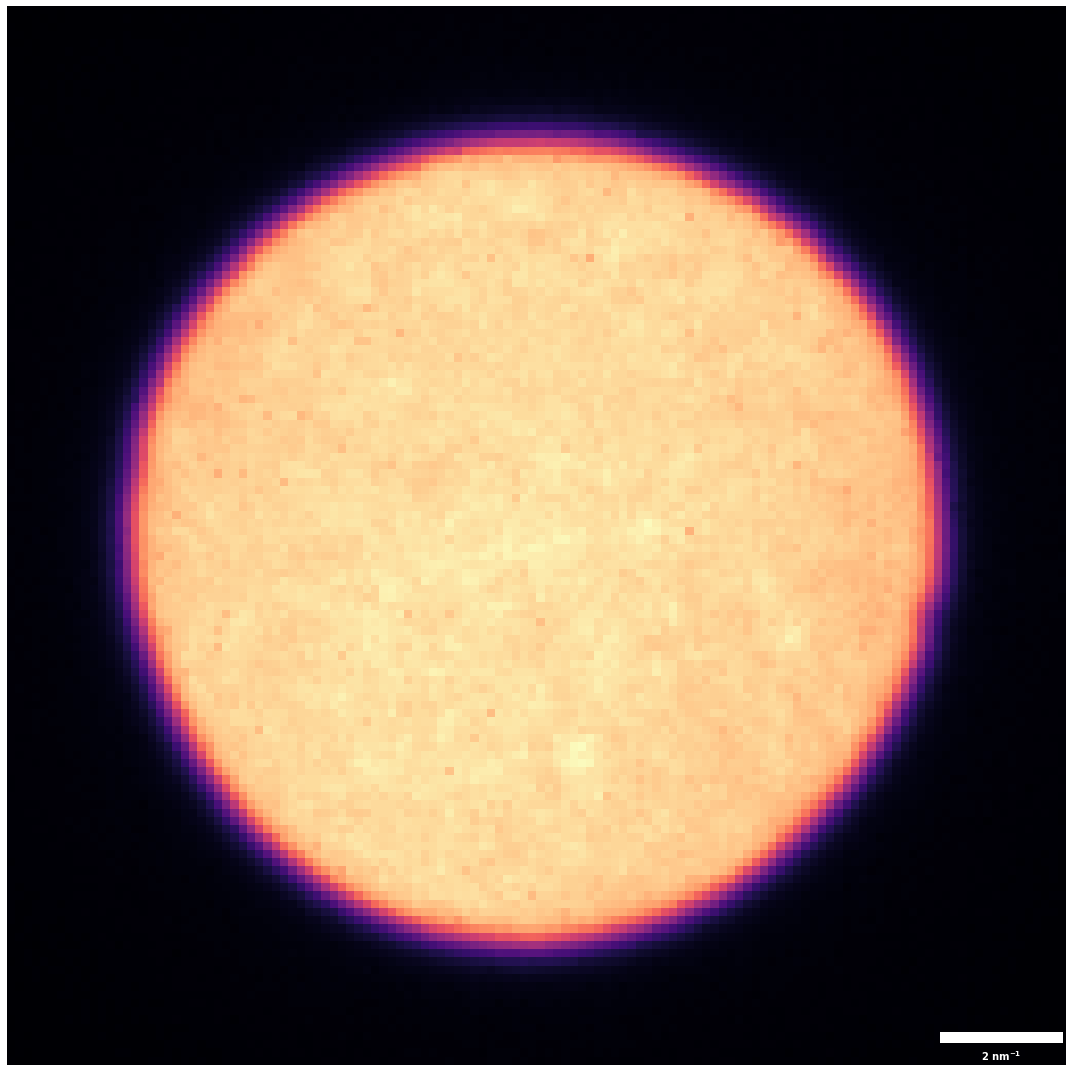

In [39]:
mr_denoised = scnd.median_filter(Mean_Ronchigram, 1)
plt.figure(figsize=(15,15))
plt.imshow(mr_denoised)
plt.axis('off')
scalebar = ScaleBar(fourier_calibration_nm,'1/nm', SI_LENGTH_RECIPROCAL)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)

plt.savefig('DenoisedMeanRonchigram.png',dpi=400)

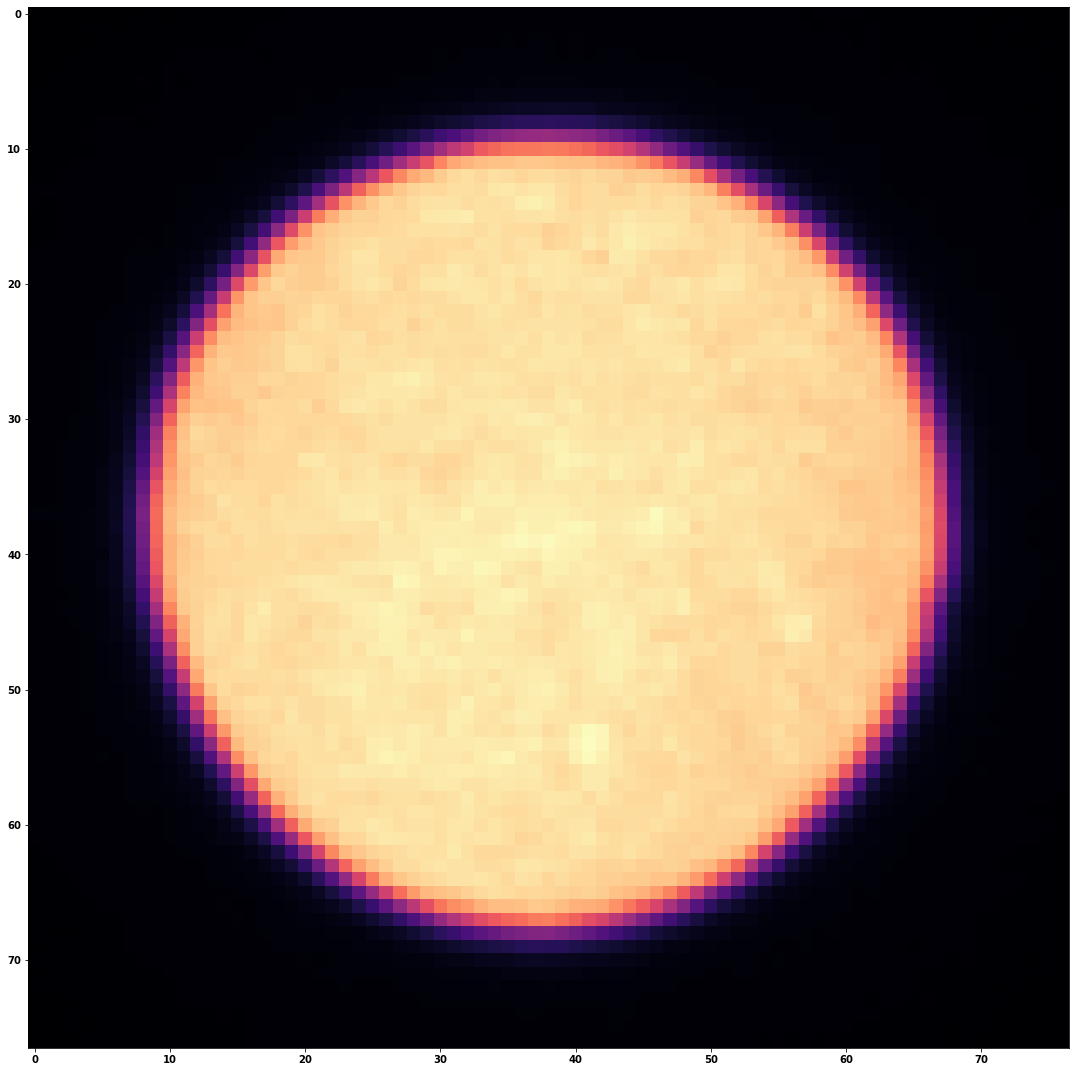

In [40]:
plt.figure(figsize=(15,15))
plt.imshow(st.util.resizer2D(Mean_Ronchigram,(1/sampling_ratio)))

In [41]:
@numba.jit(parallel=True)
def denoised_4D(original_4D,median_factor):
    data_size = (np.asarray(original_4D.shape)).astype(int)
    denoised_4D = (np.zeros((data_size[0],data_size[1],data_size[2],data_size[3])))
    for jj in numba.prange(data_size[3]):
        for ii in range(data_size[2]):
            ronchigram = original_4D[:,:,ii,jj]
            denoised_ronchi = scnd.median_filter(ronchigram, median_factor)
            denoised_4D[:,:,ii,jj] = denoised_ronchi
    return denoised_4D

In [42]:
@numba.jit
def sample_4D(original_4D,sampling_ratio=2):
    data_size = (np.asarray(original_4D.shape)).astype(int)
    processed_4D = (np.zeros((data_size[2],data_size[3],data_size[2],data_size[3])))
    for jj in range(data_size[3]):
        for ii in range(data_size[2]):
            ronchigram = original_4D[:,:,ii,jj]
            ronchi_size = (np.asarray(ronchigram.shape)).astype(int)
            resized_ronchigram = st.util.resizer2D((ronchigram + 1),(1/sampling_ratio)) - 1
            resized_shape = (np.asarray(resized_ronchigram.shape)).astype(int)
            cut_shape = (np.asarray(resized_ronchigram.shape)).astype(int)
            BeforePadSize = ((0.5 * ((data_size[2],data_size[3]) - cut_shape)) - 0.25).astype(int)
            padCorrect = (data_size[2],data_size[3]) - (cut_shape + (2*BeforePadSize))
            AfterPadSize = BeforePadSize + padCorrect
            FullPadSize = ((BeforePadSize[0],AfterPadSize[0]),(BeforePadSize[1],AfterPadSize[1]))
            padValue = np.amin(resized_ronchigram)
            padded_ronchi = np.pad(resized_ronchigram, FullPadSize, 'constant', constant_values=(padValue, padValue))
            processed_4D[:,:,ii,jj] = padded_ronchi
    return processed_4D

In [43]:
st.tic()
resized_data = sample_4D(data_rc,sampling_ratio)
st.toc()

Elapsed time: 348.817112 seconds.



In [44]:
diffractogram_intensity = np.sum(np.mean(resized_data,axis=(2,3)))
mainbeam_intensity = (np.abs(tt) ** 2).sum()
intensity_changer = (mainbeam_intensity/diffractogram_intensity) ** 0.5

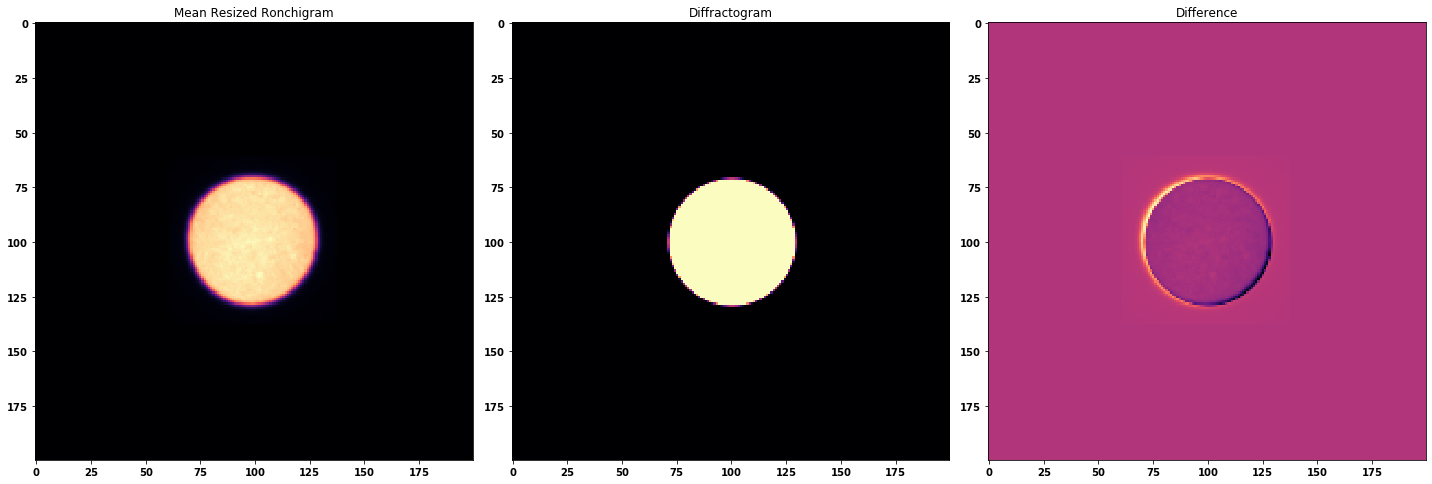

In [45]:
Meanr = np.mean(resized_data,axis=(2,3))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(Meanr)
plt.title('Mean Resized Ronchigram')

plt.subplot(1,3,2)
plt.imshow(np.abs(tt) ** 2)
plt.title('Diffractogram')

plt.subplot(1,3,3)
plt.imshow(Meanr - ((np.abs(tt) / intensity_changer) ** 2))
plt.title('Difference')

plt.savefig("ResizedData.png")

In [46]:
st.tic()
dataFT = np.fft.fftshift((np.fft.fft2(resized_data,axes=(2,3))),axes=(2,3))
st.toc()

Elapsed time: 88.654089 seconds.



In [47]:
dataSize = (np.asarray(dataFT.shape)).astype(int)
dataSize

array([200, 200, 200, 200])

In [48]:
image_x = int(dataSize[2])
image_y = int(dataSize[3])
st.tic()
wb = fft_wigner_probe(aperture_mrad,voltage,image_x,image_y,pixel_calibration_pm,intensity_changer)
st.toc()

Elapsed time: 239.705308 seconds.



In [49]:
wb.shape

(200, 200, 200, 200)

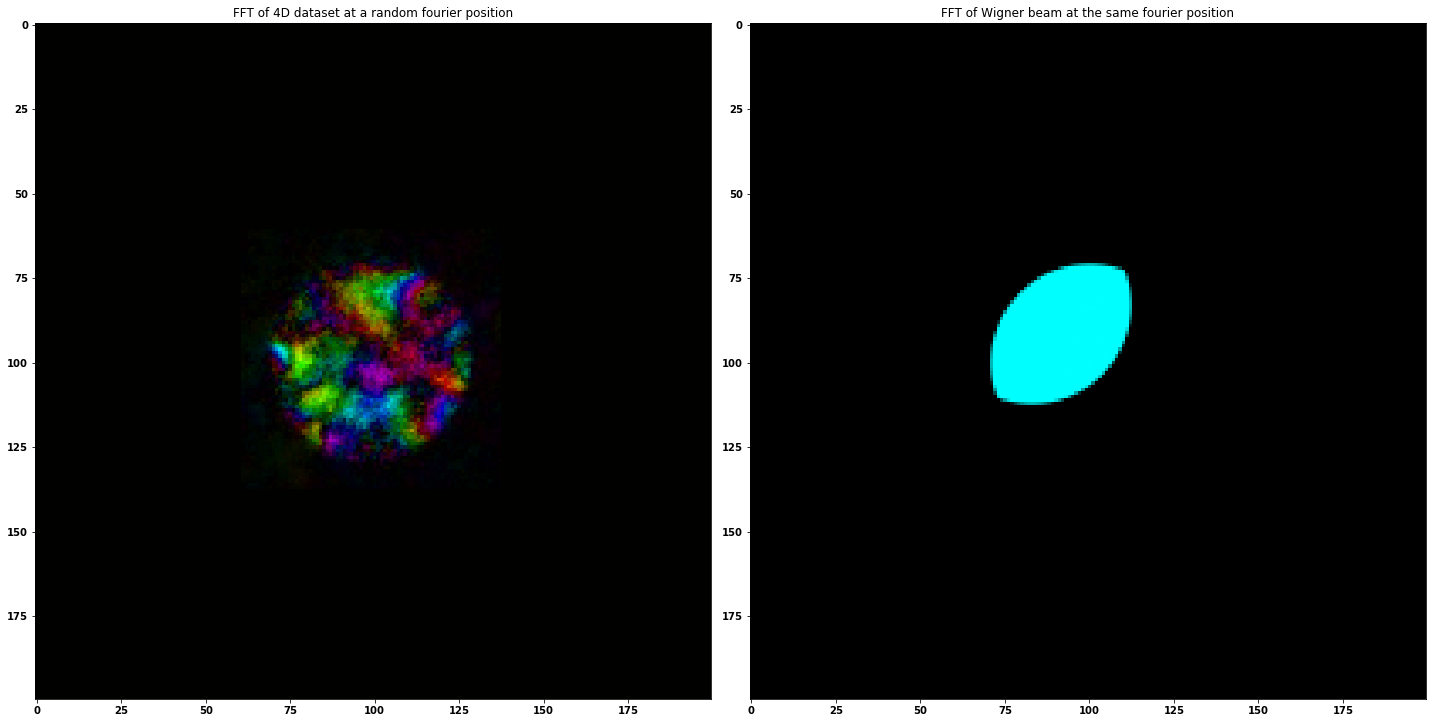

In [50]:
posx = 117
posy = 117
rand_fft_data = dataFT[:,:,posx,posy]
rand_wig = wb[:,:,posx,posy]

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(cp_image_val(rand_fft_data))
plt.title('FFT of 4D dataset at a random fourier position')

plt.subplot(1,2,2)
plt.imshow(cp_image_val(rand_wig))
plt.title('FFT of Wigner beam at the same fourier position')

plt.savefig('FFT_data_wigner.png',dpi=400)

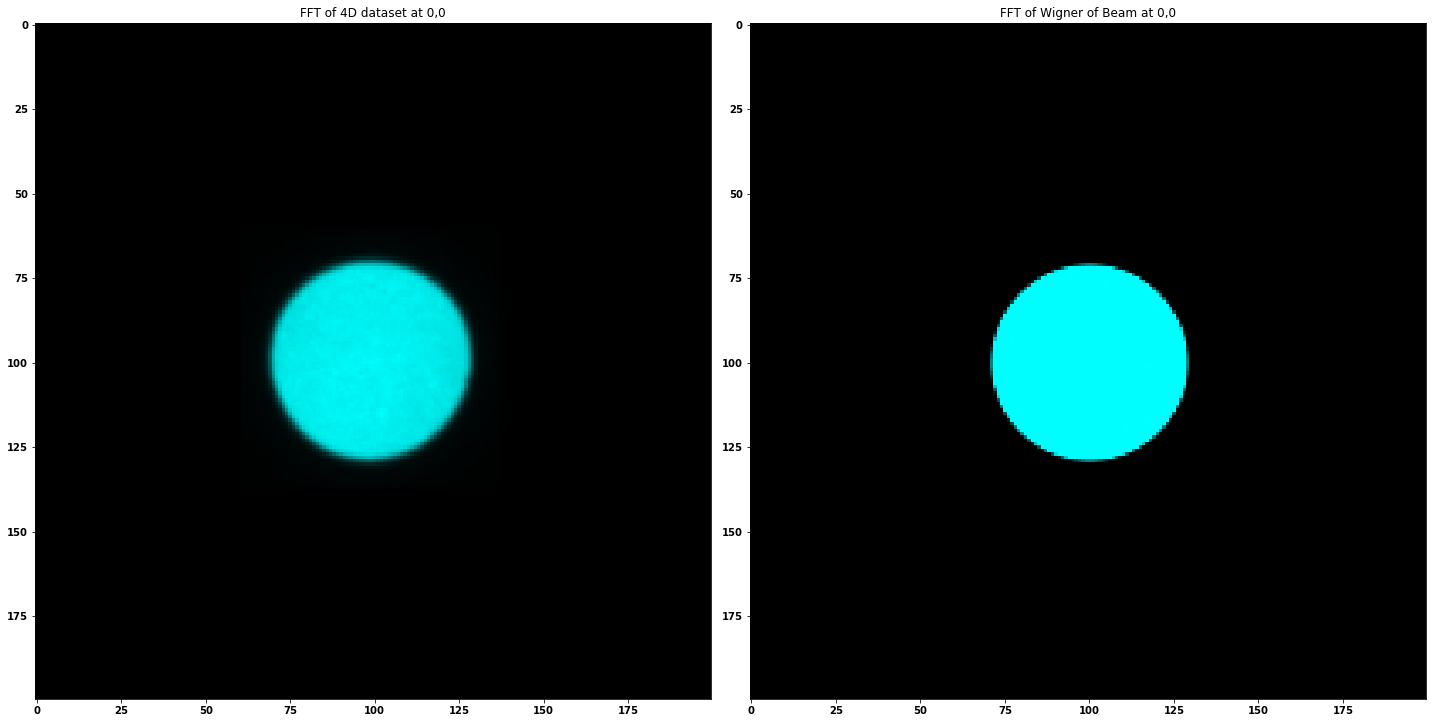

In [51]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(cp_image_val(dataFT[:,:,100,100]))
plt.title('FFT of 4D dataset at 0,0')

plt.subplot(1,2,2)
plt.imshow(cp_image_val(wb[:,:,100,100]))
plt.title('FFT of Wigner of Beam at 0,0')

plt.savefig("FFT_data_wigner_CentralDisk.png")

In [52]:
intensity_ratio = (np.sum(np.abs(dataFT[:,:,100,100]))) / (np.sum(np.abs(wb[:,:,100,100]) ** 2))
intensity_ratio

29.652354227363112

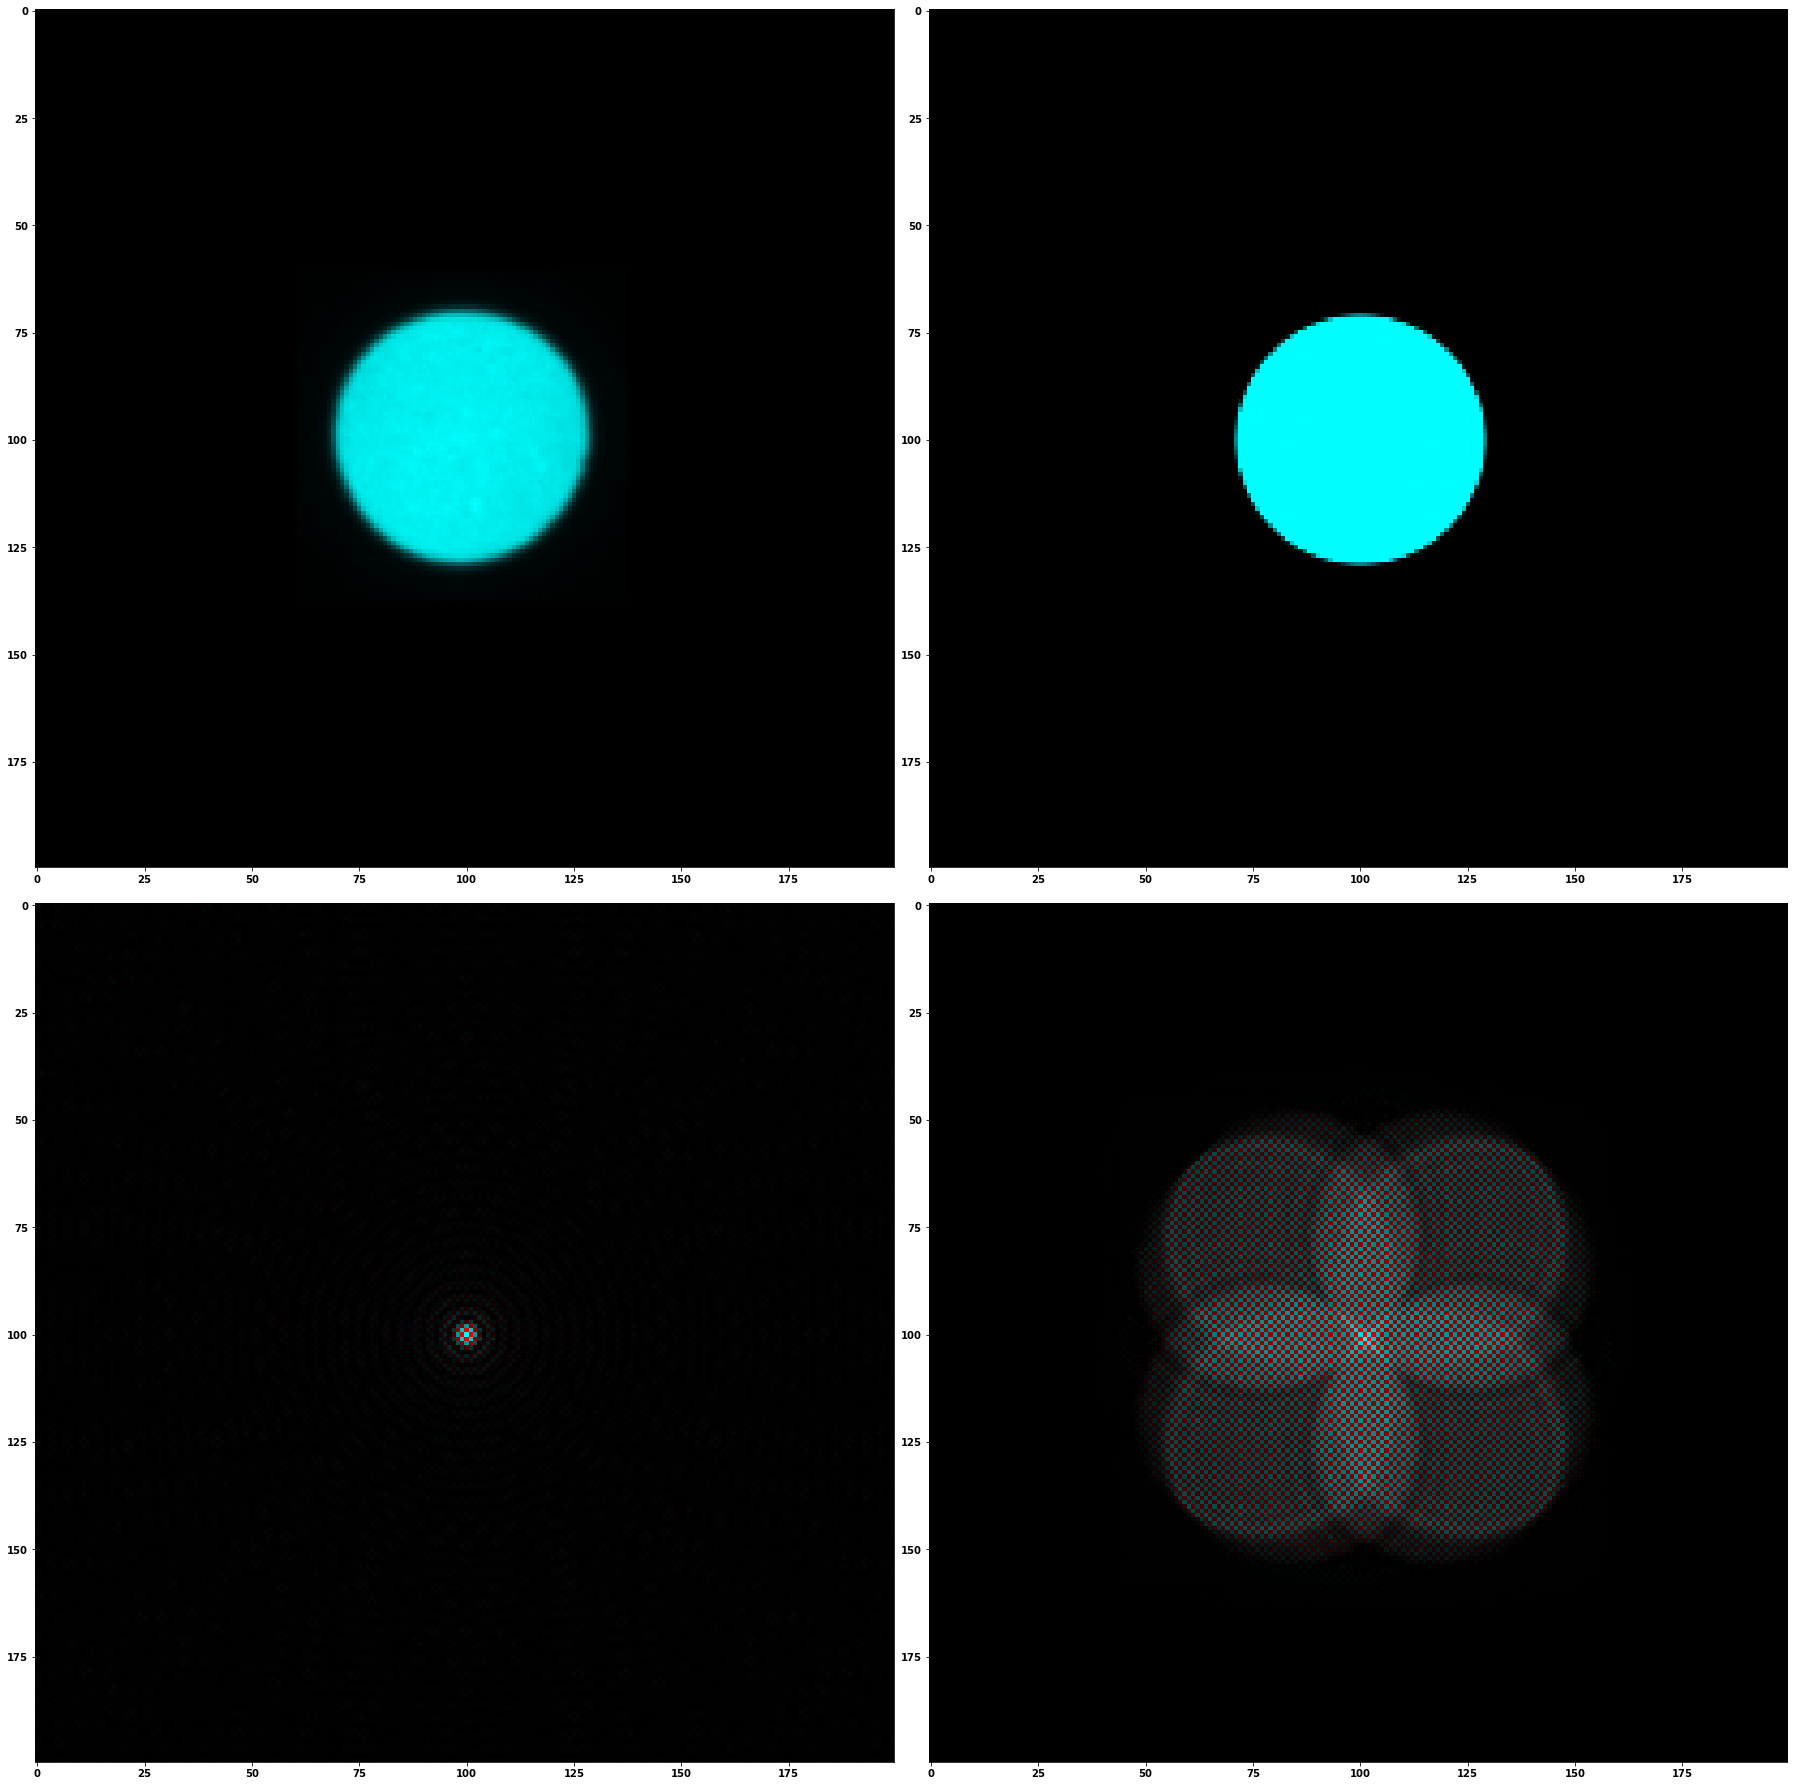

In [53]:
x = 100
y = 100
plt.figure(figsize=(25, 25))
plt.subplot(2,2,1)
plt.imshow(cp_image_val(dataFT[:,:,x,y]))
plt.subplot(2,2,2)
plt.imshow(cp_image_val(wb[:,:,x,y]))
plt.subplot(2,2,3)
plt.imshow(cp_image_val(my_wiener(np.fft.fft2(dataFT[:,:,x,y]),np.fft.fft2(wb[:,:,x,y]))))
plt.subplot(2,2,4)
plt.imshow(cp_image_val(my_wiener(dataFT[:,:,x,y],wb[:,:,x,y])))

In [54]:
@numba.jit(parallel=True)
def deconv_WDD(data4D,beamwigner):
    size_data = (np.asarray(data4D.shape)).astype(int)
    Psi4D = np.zeros(size_data,dtype='complex128')
    for jj in numba.prange(size_data[3]):
        for ii in range(size_data[2]):
            datapoint = data4D[:,:,ii,jj]
            wignerpoint = beamwigner[:,:,ii,jj]
            deconv = my_wiener(datapoint,wignerpoint)
            Psi4D[:,:,ii,jj] = deconv
    return Psi4D

In [55]:
st.tic()
dataIFT = np.fft.ifftshift((np.fft.ifft2(dataFT,axes=(0,1))),axes=(0,1))
st.toc()

Elapsed time: 95.331597 seconds.



In [56]:
st.tic()
iwb = np.fft.ifftshift((np.fft.ifft2(wb,axes=(0,1))),axes=(0,1))
st.toc()

Elapsed time: 100.905832 seconds.



In [57]:
@numba.jit
def sparse_division(sparse_num,sparse_denom,bit_depth):
    depth_ratio = 2 ** bit_depth
    denom_abs = np.abs(sparse_denom)
    threshold = (np.amax(denom_abs))/depth_ratio
    threshold_indices = denom_abs < threshold
    sparse_denom[threshold_indices] = 1
    divided_matrix = np.divide(sparse_num,sparse_denom)
    divided_matrix[threshold_indices] = 0
    return divided_matrix

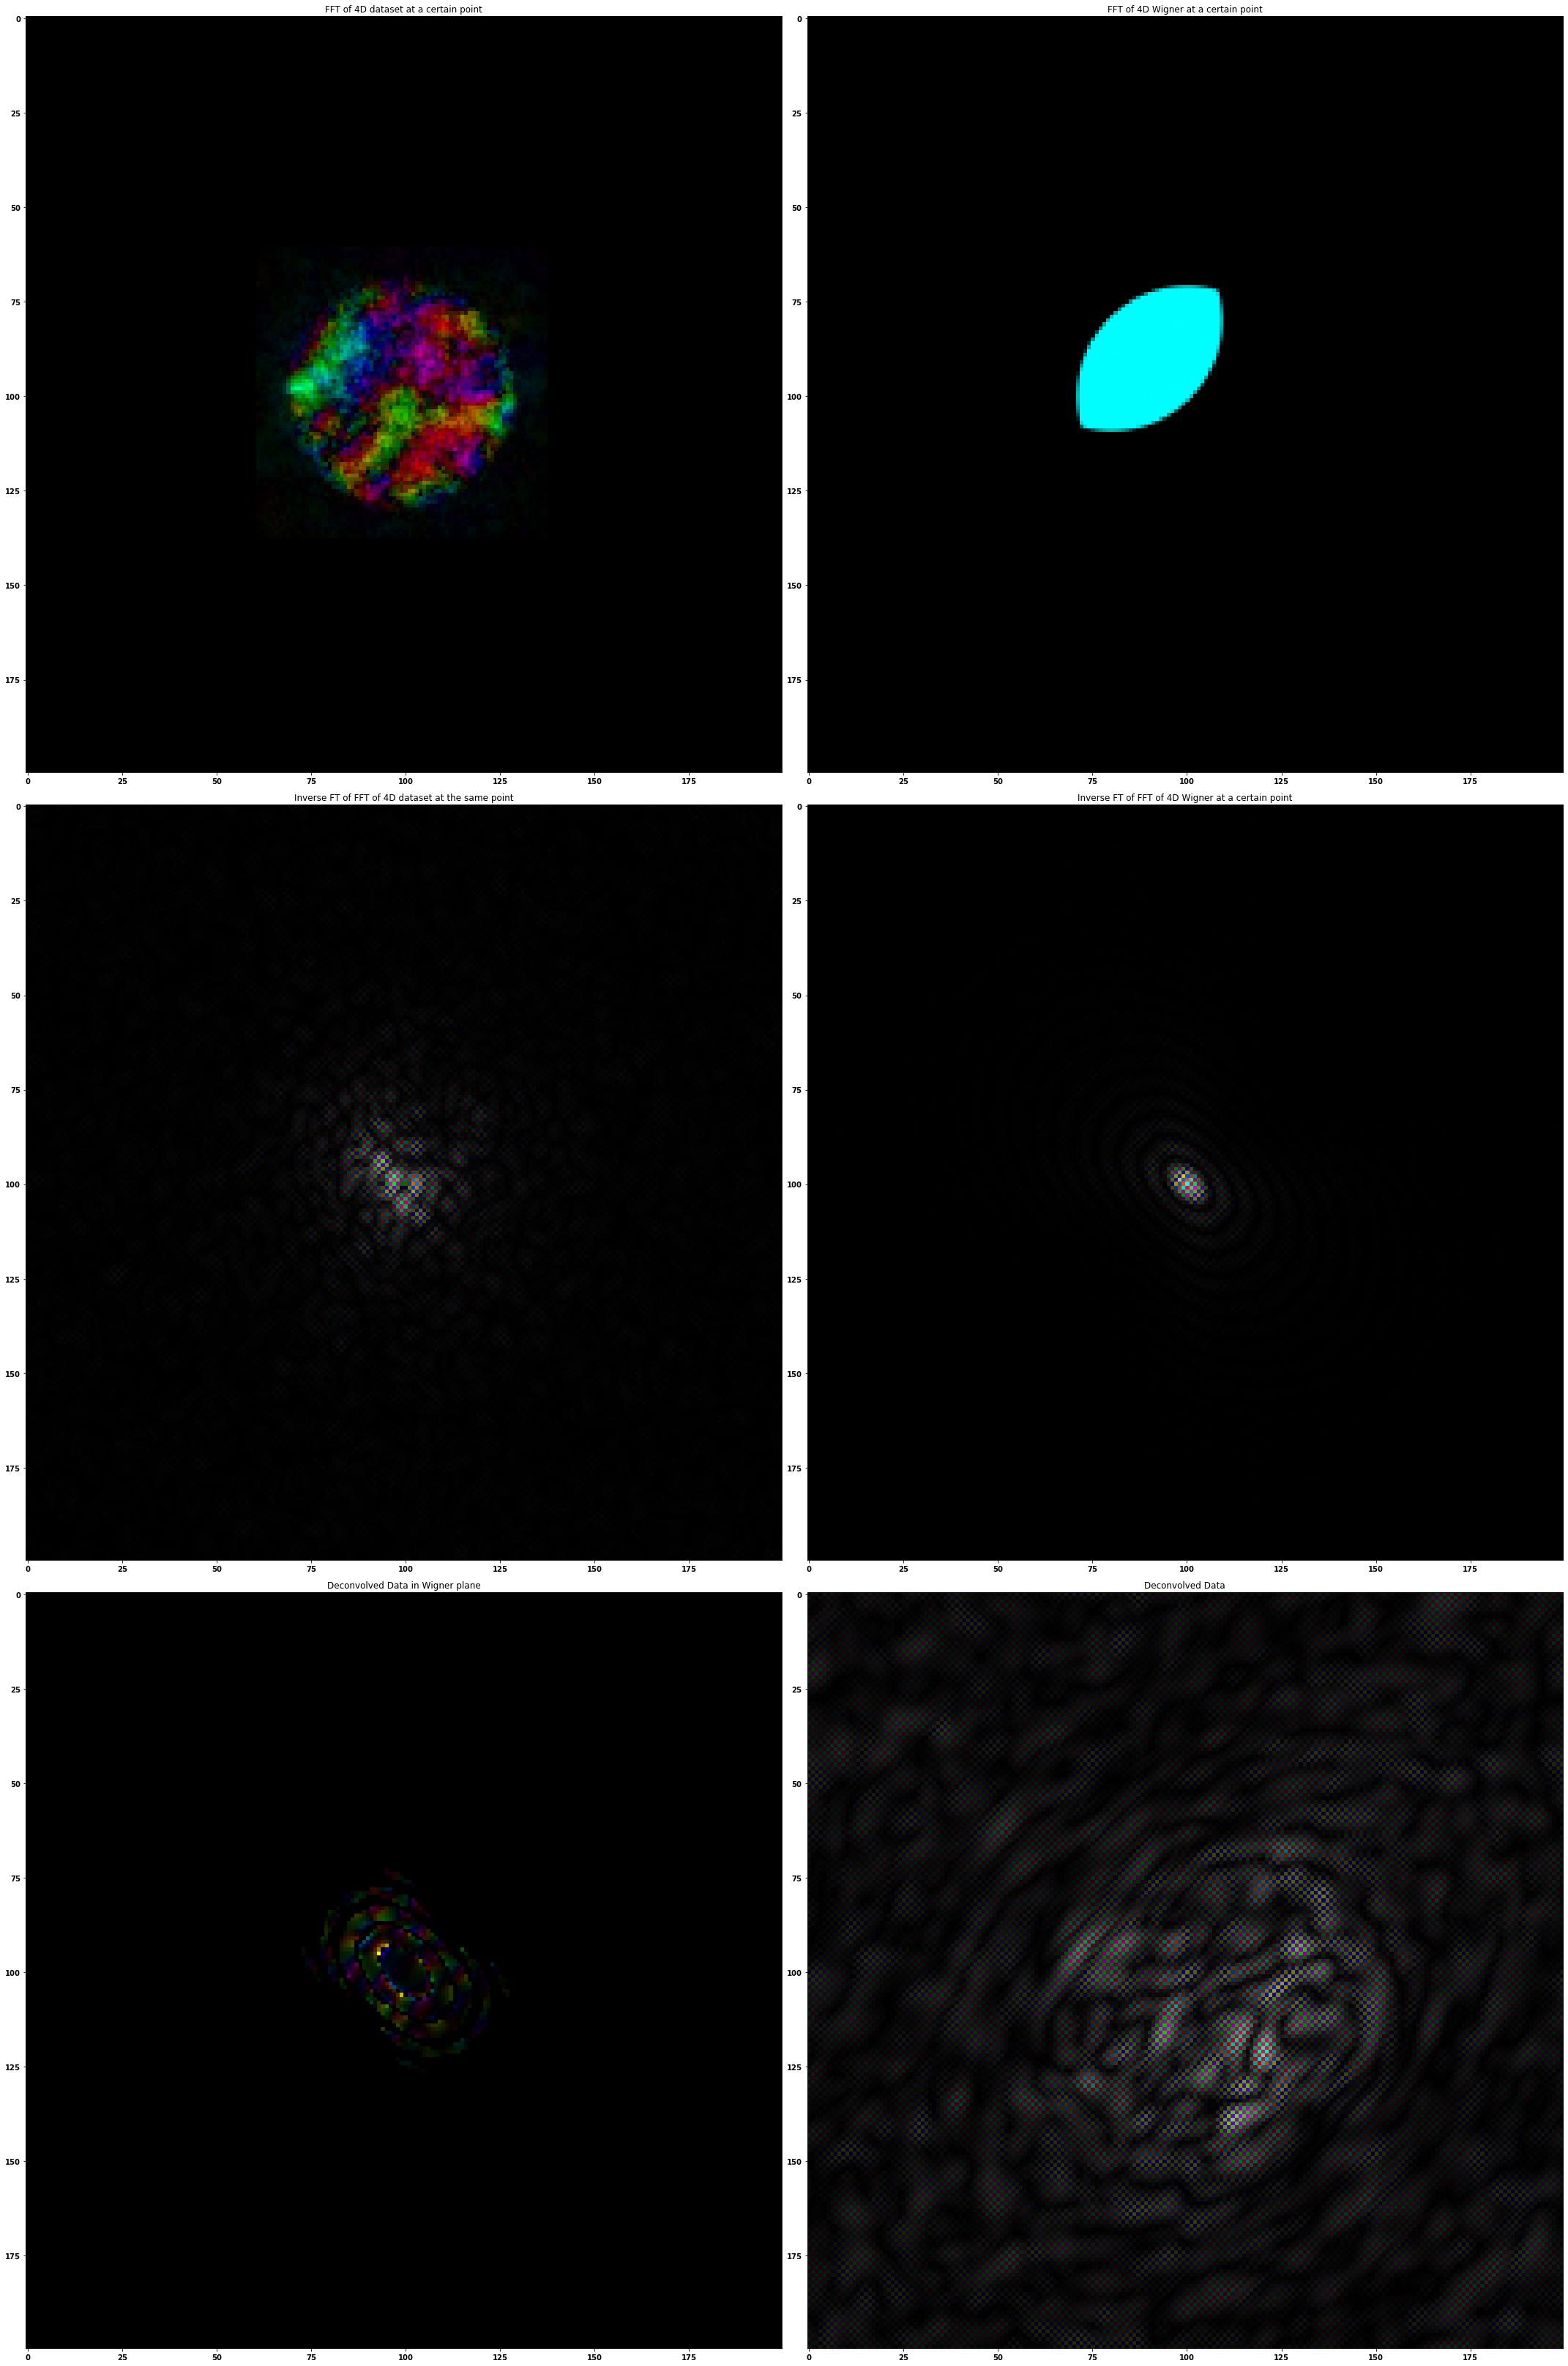

In [58]:
x = 120
y = 120
wigner_conj = np.conj(iwb[:,:,x,y])
wigner_abs = np.abs(iwb[:,:,x,y])
data_mult = np.multiply(dataIFT[:,:,x,y],wigner_conj)
deconv = sparse_division(data_mult,(wigner_abs ** 2),10)

plt.figure(figsize=(30, 45))
plt.subplot(3,2,1)
plt.imshow(cp_image_val(dataFT[:,:,x,y]))
plt.title('FFT of 4D dataset at a certain point')

plt.subplot(3,2,2)
plt.imshow(cp_image_val(wb[:,:,x,y]))
plt.title('FFT of 4D Wigner at a certain point')

plt.subplot(3,2,3)
plt.imshow(cp_image_val(dataIFT[:,:,x,y]))
plt.title('Inverse FT of FFT of 4D dataset at the same point')

plt.subplot(3,2,4)
plt.imshow(cp_image_val(iwb[:,:,x,y]))
plt.title('Inverse FT of FFT of 4D Wigner at a certain point')

plt.subplot(3,2,5)
plt.imshow(cp_image_val(deconv))
plt.title('Deconvolved Data in Wigner plane')

plt.subplot(3,2,6)
plt.imshow(cp_image_val(np.fft.fftshift(np.fft.fft2(deconv))))
plt.title('Deconvolved Data')

plt.savefig("DeconvolutionProcess.png")

In [59]:
@numba.jit
def psi_multiply(data_iff, beam_wig):
    data_size = (np.asarray(data_iff.shape)).astype(int)
    multiplied_data = (np.zeros((data_size[0],data_size[1],data_size[2],data_size[3]))).astype('complex128')
    for jj in range(data_size[3]):
        for ii in range(data_size[2]):
            iff = data_iff[:,:,ii,jj]
            wig = beam_wig[:,:,ii,jj]
            psi = np.multiply(iff,np.conj(wig))
            multiplied_data[:,:,ii,jj] = psi
    return multiplied_data

In [60]:
@numba.jit
def sparse4D(numer4D,denom4D,bit_depth):
    data_size = (np.asarray(numer4D.shape)).astype(int)
    sparse_divided = (np.zeros((data_size[0],data_size[1],data_size[2],data_size[3]))).astype('complex128')
    for jj in range(data_size[3]):
        for ii in range(data_size[2]):
            numer = numer4D[:,:,ii,jj]
            denom = denom4D[:,:,ii,jj]
            psi = sparse_division(numer,denom,bit_depth)
            sparse_divided[:,:,ii,jj] = psi
    return sparse_divided

In [ ]:
@numba.jit
def nova4D(data4D_fft,wigner4D,bit_depth):
    data_size = (np.asarray(data4D_fft.shape)).astype(int)
    processed4D = (np.zeros((data_size[0],data_size[1],data_size[2],data_size[3]))).astype('complex128')
    for jj in range(data_size[3]):
        for ii in range(data_size[2]):
            wig = wb[:,:,ii,jj]
            data_ft = data4D_fft[:,:,ii,jj]
            wig_ift = np.fft.ifftshift((np.fft.ifft2(wig)))
            data_ift = np.fft.ifftshift((np.fft.ifft2(data_ft)))
            data_mult = np.multiply(data_ift,np.conj(wig_ift))
            wigner_abs = np.abs(wig_ift)
            deconv_data = sparse_division(data_mult,(wigner_abs ** 2),bit_depth)
            deconv_ft = np.fft.fftshift(np.fft.fft2(deconv_data))
            processed4D[:,:,ii,jj] = deconv_ft
    return processed4D

In [ ]:
test_beam.shape

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(cp_image_val(Psi_WDD[100,100,:,:]))

In [ ]:
@numba.jit
def fft_wigner_data(image_data):
    size_image = (np.asarray(image_data.shape)).astype(int)
    fourier_image = np.fft.fftshift(np.fft.fft2(image_data))
    wigner_image = (np.zeros((size_image[0],size_image[1],size_image[0],size_image[1]))).astype('complex128')
    for rows_x in range(size_image[0]):
        for rows_y in range(size_image[1]):
            xpos = rows_x - (size_image[0]/2)
            ypos = rows_y - (size_image[1]/2)
            moved_fourier_image_real = scnd.interpolation.shift(np.real(fourier_image),(xpos,ypos))
            moved_fourier_image_imag = scnd.interpolation.shift(np.imag(fourier_image),(xpos,ypos))
            moved_fourier_image = moved_fourier_image_real + ((1j)*moved_fourier_image_imag)
            convolved_image = np.multiply(np.conj(fourier_image),moved_fourier_image)
            wigner_image[:,:,rows_x,rows_y] = convolved_image
    return np.fft.ifftshift(np.fft.ifft2(wigner_image,axes=(0,1)),axes=(0,1))

In [ ]:
st.tic()
wim = fft_wigner_data(dataADF[0:chop_pixel,0:chop_pixel] ** 0.5)
st.toc()

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(np.log10(np.abs((iwb[:,:,100,100]))))

In [ ]:
pixel_calibration_nm = pixel_calibration_pm/1000

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(-(np.abs(np.fft.fft2(np.multiply((Psi_Wigner[101,101,:,:]),test_beam)))))
scalebar = ScaleBar(pixel_calibration_nm,'nm')
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')
plt.tight_layout()
plt.savefig('PtychoWS2.png',dpi=400)

In [ ]:
dataADF.shape

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(np.rot90(np.rot90(dataADF))[-200:-1,-200:-1])
scalebar = ScaleBar(pixel_calibration_nm,'nm')
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')
plt.tight_layout()
plt.savefig('ADF_MoSe2.png',dpi=400)

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(np.rot90(np.rot90(np.sum(data_rc,axis=(0,1)))))
scalebar = ScaleBar(pixel_calibration_nm,'nm')
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')
plt.tight_layout()
plt.savefig('BF_MoSe2.png',dpi=400)

In [ ]:
@numba.jit
def image_tiler(dataset_4D,reducer,bit_depth):
    size_data = (np.asarray(dataset_4D.shape)).astype(int)
    normalized_4D = (dataset_4D - np.amin(dataset_4D))/(np.amax(dataset_4D) - np.amin(dataset_4D))
    reduced_size = np.zeros(2)
    reduced_size[0:2] = np.round(size_data[0:2]*(1/reducer))
    reduced_size = reduced_size.astype(int)
    tile_size = np.multiply(reduced_size,(size_data[2],size_data[3]))
    image_tile = np.zeros(tile_size)
    for jj in range(size_data[3]):
        for ii in range(size_data[2]):
            ronchi = normalized_4D[:,:,ii,jj]
            xRange = (ii * reduced_size[0]) + np.arange(reduced_size[0])
            xStart = int(xRange[0])
            xEnd = 1 + int(xRange[-1])
            yRange = (jj * reduced_size[1]) + np.arange(reduced_size[1])
            yStart = int(yRange[0])
            yEnd = 1 + int(yRange[-1])
            image_tile[xStart:xEnd,yStart:yEnd] = st.util.resizer2D((ronchi + 1),reducer) - 1
    image_tile = image_tile - np.amin(image_tile)
    image_tile = (2 ** bit_depth)*(image_tile/(np.amax(image_tile)))
    image_tile = image_tile.astype(int)
    return image_tile

In [ ]:
%timeit image_tiler(data_rc[:,:,0:20,0:20],4,8)

In [ ]:
st.tic()
tiled_data = image_tiler(data_rc,4,8)
st.toc()

In [ ]:
tiled_data.shape

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(tiled_data)
plt.axis('off')
plt.savefig('Tiled_4D_Data.png',dpi=320)

In [ ]:
whos